The following analysis was executed using commit `b6e4fe952` of the [exosyspop](github.com/timothydmorton/exosyspop) module.

In [1]:
# Set up plot stuff the DFM way:
%matplotlib inline
import matplotlib.pyplot as plt

%run ../peerless/plot_setup.py

In [76]:
!../scripts/peerless-targets

Saving 39036 targets to /Users/tdm/peerless/catalogs/targets.csv


In [79]:
from peerless.catalogs import TargetCatalog, EBCatalog
targets = TargetCatalog().df

In [80]:
targets[['kepid','mass','feh']].count()

kepid    39036
mass     38410
feh      39036
dtype: int64

In [81]:
# funny, there seem to be some missing masses.  Let's artificially add those in, with M=R
bad = targets.mass.isnull()
targets.loc[bad, 'mass'] = targets.loc[bad, 'radius']

In [82]:
# Calculate galactic latitude of target stars
from astropy.coordinates import SkyCoord
c = SkyCoord(targets.ra, targets.dec, unit='deg')
targets['b'] = c.galactic.b.deg

In [83]:
from exosyspop.populations import KeplerPowerLawBinaryPopulation
from exosyspop.populations import TRILEGAL_BGPowerLawBinaryPopulation

ebpop = KeplerPowerLawBinaryPopulation(targets, ecc_empirical=True)
bgstars = pd.read_hdf('bgstars.h5', 'df')
bgpop = TRILEGAL_BGPowerLawBinaryPopulation(targets, bgstars, ecc_empirical=True, use_ic=True)

136.401367662
153


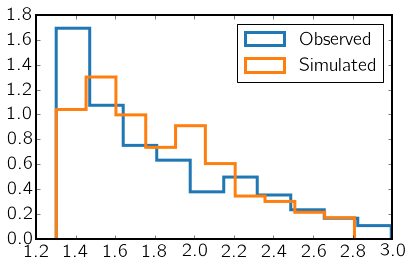

In [108]:
from __future__ import division

min_period = 20
max_period = 25*365.25
fB = 0.15
beta = -1.1
ebpop.set_params(beta=beta, period_min=min_period, period_max=max_period, fB=fB)

q = 'period > {} and period < 1000 and '.format(min_period) +\
    '((n_pri > 0 and n_sec > 0) or ' +\
     '(n_pri > 2 or n_sec > 2)) and (T14_pri < 2.5 or T14_sec < 2.5)'

kep_ebs = EBCatalog().df.query('{} < period < 1000'.format(min_period))
n_exp = len(kep_ebs) * (len(targets)/len(KICatalog().df))
print(n_exp)
plt.hist(np.log10(kep_ebs.period), 
         histtype='step', lw=3, normed=True, label='Observed');
new_obs = ebpop.observe(new_orbits=True).query(q)
plt.hist(np.log10(new_obs.period), label='Simulated',
        histtype='step', lw=3, normed=True);
plt.legend()
print(len(new_obs))

In [109]:
ebpop.params

{'beta': -1.1,
 'beta_a': 0.8,
 'beta_b': 2.0,
 'fB': 0.15,
 'gamma': 0.3,
 'period_max': 9131.25,
 'period_min': 20,
 'qmin': 0.1}

In [110]:
# Set params to match above
pars = dict(period_min=min_period, period_max=max_period, beta=beta, fB=fB)
ebpop.set_params(**pars)
bgpop.set_params(**pars)
ebpop._generate_binaries()
bgpop._generate_binaries()

Let's do a bunch of these observation simulations and see what it looks like:

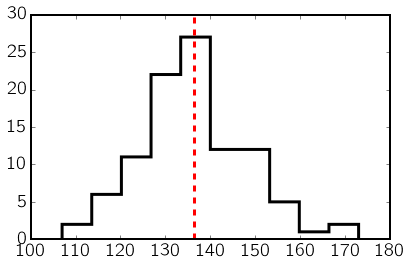

In [111]:
n_obs = [len(ebpop.observe(new_orbits=True).query(q)) for i in range(100)]

plt.hist(n_obs, histtype='step', lw=3, bins=10, color='k');
plt.axvline(n_exp, color='r', ls='--', lw=3);

OK, now that we can roughly match the Kepler EB catalog from 20 to 1000d with these EB population parameters, we want to know what's the typical number of single/double eclipse signals.

In [112]:
ebpop._train_trap(N=1000);
bgpop._train_trap(N=1000);

EB: Depth trained: R2=0.998841943165
EB: Duration trained: R2=0.997435262402
EB: Slope trained: R2=0.980777458662
BGEB: Depth trained: R2=0.994487728442
BGEB: Duration trained: R2=0.998174985036
BGEB: Slope trained: R2=0.985989102635


In [113]:
n_sim = 100
dfm_q = 'n_pri < 3 and n_sec < 3 and ((n_pri==0 and snr_sec > 15) or (n_sec==0 and snr_pri > 15))'
dfm_q += ' and ((T14_pri < 2.5 and n_pri > 0) or (T14_sec < 2.5 and n_sec > 0))'
nobs_eb = [len(ebpop.observe(new_orbits=True, regr_trap=True).query(dfm_q)) for i in range(n_sim)]
nobs_bg = [len(bgpop.observe(new_orbits=True, regr_trap=True).query(dfm_q)) for i in range(n_sim)]

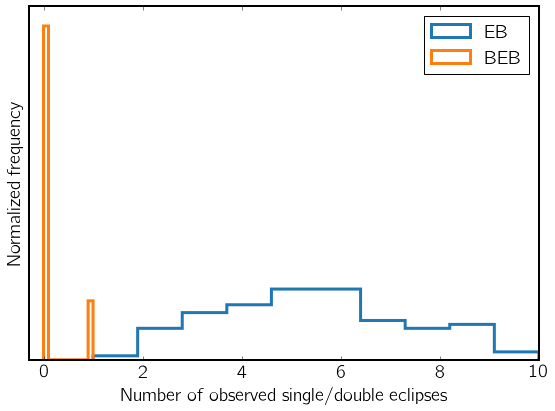

In [114]:
plt.figure(figsize=(8,6))
plt.hist(nobs_eb, histtype='step', lw=3, label='EB')#, bins=np.arange(16));
plt.hist(nobs_bg, histtype='step', lw=3, label='BEB')#, bins=np.arange(16));
plt.legend();
plt.xlim(xmin=-0.3)
plt.yticks([])
plt.ylabel('Normalized frequency')
plt.xlabel('Number of observed single/double eclipses');
plt.savefig('N_EBs.pdf', bbox_inches='tight')

OK, now let's determine the typical shapes.  Let's do this with a big sample of simulated observations.

In [115]:
np.mean(nobs_eb), np.mean(nobs_bg)

(5.4199999999999999, 0.14999999999999999)

In [116]:
eb_obs = ebpop.get_N_observed(query=dfm_q, N=2000, new_orbits=True)
bg_obs = bgpop.get_N_observed(query=dfm_q, N=200, use_ic=True, new_orbits=True) #takes longer; use fewer

OK, now let's load up the candidates.

In [117]:
candidates = pd.read_csv('../results/candidates.csv').query('accept_bic and accept_time and num_peaks <= 2')
candidates[['depth','transit_duration','s2n']].head()

,depth,transit_duration,s2n
6,0.000346,0.716957,28.485282
33,0.004086,0.496911,78.893061
35,0.000881,0.405306,34.391561
47,0.003687,0.515208,88.882287
52,0.009443,0.430771,193.284575


In [118]:
candidates.s2n.min()

18.096212254112913

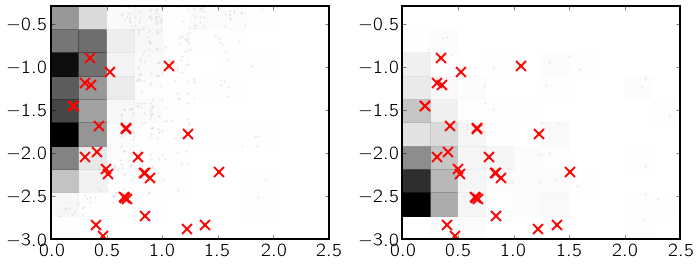

In [119]:
from corner import hist2d

fix, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

hist2d(eb_obs.observed.dur_pri.values, eb_obs.observed.logd_pri.values,
          plot_contours=False, ax=ax1, range=[(0,2.5), (-3, -0.3)], bins=10);
hist2d(bg_obs.observed.dur_pri.values, bg_obs.observed.logd_pri.values,
          plot_contours=False, ax=ax2, range=[(0,2.5), (-3, -0.3)], bins=10);

for ax in (ax1, ax2):
    ax.plot(candidates.transit_duration, np.log10(candidates.transit_depth), 'rx', ms=10)


In [120]:
from scipy.stats import gaussian_kde

eb_kde = gaussian_kde(np.array([eb_obs.observed.dur_pri, eb_obs.observed.logd_pri]))
bg_kde = gaussian_kde(np.array([bg_obs.observed.dur_pri, bg_obs.observed.logd_pri]))

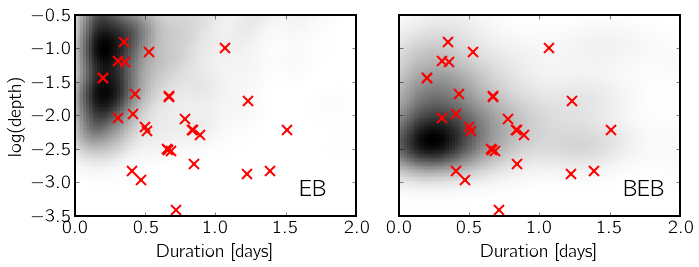

In [121]:
def plot_kde(kde, ax=None, dur_range=(0,2.), depth_range=(-3.5,-0.5), 
            cands=candidates, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    dur_grid = np.arange(dur_range[0], dur_range[1], 0.02)
    depth_grid = np.arange(depth_range[0], depth_range[1], 0.02)
    xx, yy = np.meshgrid(dur_grid, depth_grid)
    f = kde(np.vstack([xx.ravel(),yy.ravel()])).reshape(xx.shape)
    ax.imshow(f, origin='lower', extent=[dur_range[0], dur_range[1],
                                         depth_range[0], depth_range[1]], 
               aspect='auto', cmap='binary', **kwargs)
    ax.set_xlabel('Duration [days]')
    ax.set_ylabel('log(depth)')
    
    if cands is not None:
        ax.plot(cands.transit_duration, np.log10(cands.transit_depth), 'rx', ms=10)
    
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
plot_kde(eb_kde, ax=axes[0])
plot_kde(bg_kde, ax=axes[1])
axes[1].set_ylabel('')
plt.subplots_adjust(wspace=0)
for ax,title in zip(axes, ['EB','BEB']):
    ax.annotate(title, xy=(0.8,0.1), xycoords='axes fraction', fontsize=22)

In [122]:
len(candidates)

29

In [188]:
# Here, defining population to match what was fit for in the paper
from exosyspop.populations import PlanetPopulation, REARTH, RSUN

import astropy.constants as const
RJUP = const.R_jup.cgs

class LongPeriodPlanetPopulation(PlanetPopulation):
    """
    Poisson Population in two bins: 0.1-0.4 RJup and 0.4-1.0 RJup
    
    From 2 to 25 years, with beta eccentricity distribution
    """
    min_period = 2*365.25
    max_period = 25*365.25
    
    param_names = ('Gam1', 'Gam2', 'beta_a', 'beta_b')
    default_params = {'Gam1':0.24, 'Gam2':0.18,
                      'beta_a':0.8, 'beta_b':2.0}
    
    def _sample_period(self, N):
        return np.random.random(N)*(self.max_period - self.min_period) + self.min_period
    
    def _sample_Np(self, N):
        Gam1, Gam2 = self._get_params(['Gam1', 'Gam2'])
        N_pl = Gam1 + Gam2 # Sum of both bins is total rate
        return np.random.poisson(N_pl, size=N)
    
    def _sample_Rp(self, N):
        Gam1, Gam2 = self._get_params(['Gam1', 'Gam2'])
        
        # Assign radii uniformly in each bin, with appropriate ratio given to each bin
        f1 = Gam1 / (Gam1 + Gam2)
        u = np.random.random(N)
        in_1 = u < f1
        in_2 = u >= f1
        N1 = in_1.sum()
        N2 = in_2.sum()
        
        Rp = np.ones(N)
        Rp[in_1] = np.random.random(N1)*(0.3) + 0.1
        Rp[in_2] = np.random.random(N2)*(0.6) + 0.4
        return Rp * RJUP/RSUN

In [184]:
plpop = LongPeriodPlanetPopulation(targets)

In [185]:
plpop._train_trap(N=1000);

Planet: Depth trained: R2=0.998900388882
Planet: Duration trained: R2=0.997044097878
Planet: Slope trained: R2=0.980403455175


In [186]:
plpop.params

{'Gam1': 0.24, 'Gam2': 0.18, 'beta_a': 0.8, 'beta_b': 2.0}

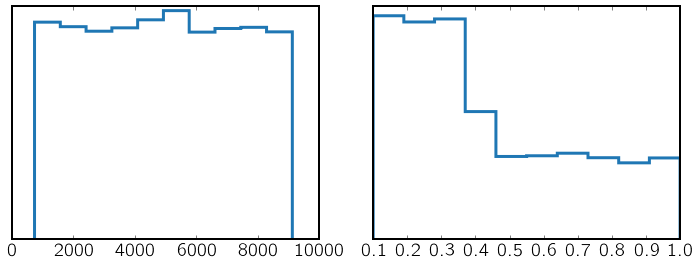

In [189]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.hist(plpop.period, histtype='step', lw=3);
ax1.set_yticks([])
ax2.hist(plpop.radius_B*RSUN/RJUP, histtype='step', lw=3);
ax2.set_yticks([]);

In [199]:
plpop.dutycycle.max()

0.87619999999999998

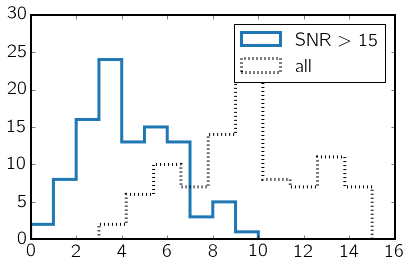

In [200]:
dfm_q_pl = 'n_pri < 3 and snr_pri > 15 and T14_pri < 2.5'
dfm_q_pl_nosnr = 'n_pri < 3 and T14_pri < 2.5 and snr_pri > 0'

nobs_pl = [len(plpop.observe(new_orbits=True, regr_trap=True).query(dfm_q_pl)) for i in range(100)]
nobs_pl2 = [len(plpop.observe(new_orbits=True, regr_trap=True).query(dfm_q_pl_nosnr)) for i in range(100)]

plt.hist(nobs_pl, histtype='step', lw=3, label='SNR $>$ 15');
plt.hist(nobs_pl2, histtype='step', lw=3, color='k', ls=':', label='all')
plt.legend(loc='upper right');

In [191]:
np.mean(nobs_pl)

3.2599999999999998

In [201]:
plpop.stars.columns

Index([u'kepid', u'tm_designation', u'teff', u'teff_err1', u'teff_err2',
       u'logg', u'logg_err1', u'logg_err2', u'feh', u'feh_err1', u'feh_err2',
       u'mass_A', u'mass_err1', u'mass_err2', u'radius', u'radius_err1',
       u'radius_err2', u'dens', u'dens_err1', u'dens_err2', u'prov_sec',
       u'kepmag', u'dist', u'dist_err1', u'dist_err2', u'nconfp', u'nkoi',
       u'ntce', u'datalink_dvr', u'st_delivname', u'st_vet_date_str', u'ra',
       u'dec', u'st_quarters', u'teff_prov', u'logg_prov', u'feh_prov',
       u'jmag', u'jmag_err', u'hmag', u'hmag_err', u'kmag', u'kmag_err',
       u'dutycycle', u'dataspan', u'mesthres01p5', u'mesthres02p0',
       u'mesthres02p5', u'mesthres03p0', u'mesthres03p5', u'mesthres04p5',
       u'mesthres05p0', u'mesthres06p0', u'mesthres07p5', u'mesthres09p0',
       u'mesthres10p5', u'mesthres12p0', u'mesthres12p5', u'mesthres15p0',
       u'rrmscdpp01p5', u'rrmscdpp02p0', u'rrmscdpp02p5', u'rrmscdpp03p0',
       u'rrmscdpp03p5', u'rrmscdpp04p5

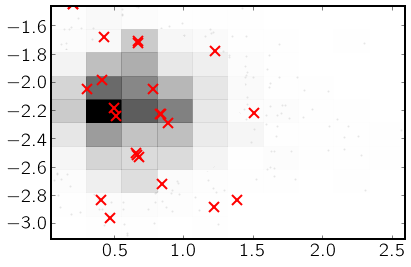

In [192]:
N = 1000
pl_obs = plpop.get_N_observed(query=dfm_q_pl, N=N)

hist2d(pl_obs.observed.dur_pri.values, pl_obs.observed.logd_pri.values,
          plot_contours=False, bins=10);

plt.plot(candidates.transit_duration, np.log10(candidates.transit_depth), 'rx', ms=10);

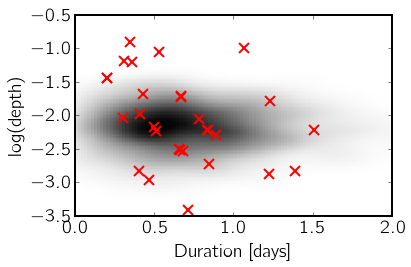

In [193]:
pl_kde = gaussian_kde(np.array([pl_obs.observed.dur_pri, pl_obs.observed.logd_pri]))
plot_kde(pl_kde)

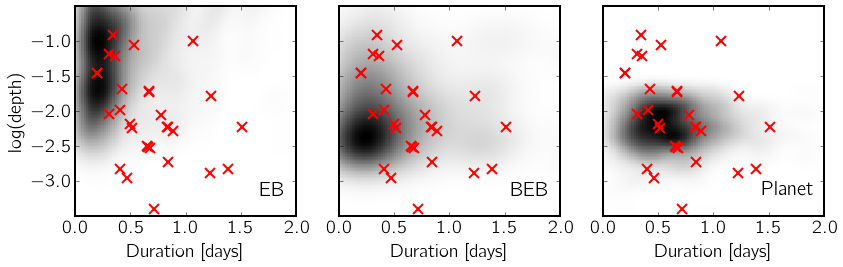

In [132]:
fig, axes = plt.subplots(1,3, figsize=(12,4), sharey=True)
plot_kde(eb_kde, ax=axes[0])
plot_kde(bg_kde, ax=axes[1])
plot_kde(pl_kde, ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
plt.subplots_adjust(wspace=0)
for ax,title in zip(axes, ['EB','BEB','Planet']):
    ax.set_yticks(np.arange(-3,-0.5,0.5))
    ax.annotate(title, xy=(0.95,0.1), xycoords='axes fraction', fontsize=20, ha='right')
    
plt.savefig('shape_kdes.pdf', bbox_inches='tight')

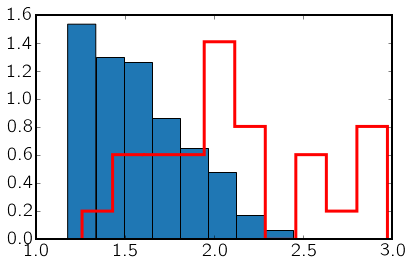

In [133]:
# Just curious...
plt.hist(np.log10(pl_obs.observed.snr_pri), normed=True);
plt.hist(np.log10(candidates.s2n.values), histtype='step', color='r', lw=3, normed=True);

OK, now we can guess as to the nature of each individual signal, given our predicted rates and the depth-duration shape information:

In [139]:
pts = [candidates.transit_duration, np.log10(candidates.transit_depth)]
L_eb = eb_kde(pts)
L_bg = bg_kde(pts)
L_pl = pl_kde(pts)

pi_eb = 7.
pi_bg = 0.25
pi_pl = 20

norm = L_eb*pi_eb + L_bg*pi_bg + L_pl*pi_pl

candidates['pr_eb'] = L_eb*pi_eb / norm
candidates['pr_bg'] = L_bg*pi_bg / norm
candidates['pr_pl'] = L_pl*pi_pl / norm

In [140]:
candidates[['pr_eb', 'pr_bg', 'pr_pl']].sum()

pr_eb     7.967018
pr_bg     0.845612
pr_pl    18.187371
dtype: float64

In [129]:
candidates[['transit_depth', 'transit_duration', 'pr_eb', 'pr_bg', 'pr_pl']]

,transit_depth,transit_duration,pr_eb,pr_bg,pr_pl
17,0.009891,0.393807,0.100521,0.006526,8.929526e-01
27,0.099859,1.157742,0.983571,0.016429,1.625674e-10
39,0.019413,0.684503,0.119688,0.007541,8.727710e-01
40,0.018614,0.684186,0.105281,0.006634,8.880846e-01
43,0.061088,0.361075,0.985850,0.013016,1.134098e-03
135,0.001466,0.368496,0.038147,0.019330,9.425233e-01
139,0.005940,0.504267,0.034349,0.004657,9.609945e-01
146,0.008761,0.736594,0.018510,0.001806,9.796848e-01
151,0.005943,1.514634,0.020482,0.003661,9.758570e-01
186,0.008697,0.295183,0.152245,0.008694,8.390618e-01
